# Compute gaia colors

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
from astropy.io import fits
from glob import glob
import astropy.units as u
from astropy.io import ascii
from astropy.table import Table

data_start = 3
gaia = ascii.read('temperatures/gaia.tsv',
                  data_start=data_start, delimiter='\t')

In [110]:
ext = [float(s) if len(s.strip()) > 0 else 0 for s in gaia['E(BP-RP)'].data]

(array([ 15.,  17.,  17.,   1.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.6427 ,  0.89971,  1.15672,  1.41373,  1.67074,  1.92775,
         2.18476,  2.44177,  2.69878,  2.95579,  3.2128 ]),
 <a list of 10 Patch objects>)

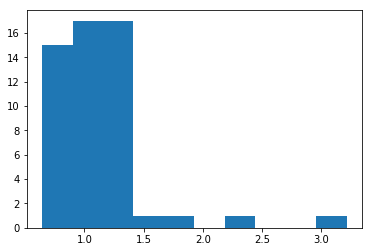

In [111]:
plt.hist(gaia['BP-RP'].data.data - np.array(ext))

In [131]:
colors = {}

for s, color in zip(gaia['_1'], gaia['BP-RP'].data.data - np.array(ext)):
    colors[s.strip().replace(' ', '').replace('-', '')] = color

In [133]:
colors['HATP11']

1.1152

In [134]:
json.dump(colors, open('colors.json', 'w'))

# Compute grid of colors for model atmospheres

In [56]:
paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

phoenix_wavelengths = fits.getdata(paths[0])['Wavelength'] 

temperatures = []
model_fluxes = []

for path in sorted(paths):
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(phoenix_wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

In [62]:
wavelength_unit = u.Unit(hdu[1].header['TUNIT1'])
flux_unit = u.Unit(hdu[1].header['TUNIT2'])

Read in Gaia bandpasses: 

In [74]:
b = ascii.read('filters/GAIA_GAIA2r.Gbp.dat.txt')
r = ascii.read('filters/GAIA_GAIA2r.Grp.dat.txt')
wl_b, trans_b = b['col1']*u.Angstrom, b['col2']
wl_r, trans_r = r['col1']*u.Angstrom, r['col2']

wavelength = phoenix_wavelengths * wavelength_unit
trans_b_phoenix = np.interp(wavelength.to(u.Angstrom).value, wl_b.to(u.Angstrom).value, trans_b)
trans_r_phoenix = np.interp(wavelength.to(u.Angstrom).value, wl_r.to(u.Angstrom).value, trans_r)

Read in Vega: 

In [75]:
a = fits.open('data/alpha_lyr_mod_002.fits')
vega_wavelength = a[1].data['Wavelength'] * u.Angstrom
vega_flux = a[1].data['Flux'] * u.Unit('erg / (s * cm^2 * Angstrom)')

trans_b_vega = np.interp(vega_wavelength.to(u.Angstrom).value, wl_b.to(u.Angstrom).value, trans_b)
trans_r_vega = np.interp(vega_wavelength.to(u.Angstrom).value, wl_r.to(u.Angstrom).value, trans_r)

In [77]:
bminusr = []

for temperature in temperatures: 
    
    wavelength = phoenix_wavelengths * wavelength_unit
    flux = model_fluxes[np.argmin(np.abs(temperatures-temperature)), :] * flux_unit
    
#     plt.plot(wavelength, flux)
    
    B = -2.5 * np.log10(np.trapz(flux * wavelength * trans_b_phoenix, wavelength) / 
                        np.trapz(vega_flux * vega_wavelength * trans_b_vega, vega_wavelength))
    R = -2.5 * np.log10(np.trapz(flux * wavelength * trans_r_phoenix, wavelength) / 
                        np.trapz(vega_flux * vega_wavelength * trans_r_vega, vega_wavelength))

    bminusr.append(B-R)

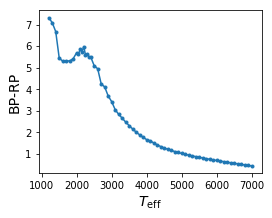

In [104]:
plt.figure(figsize=(4,3))
plt.plot(temperatures, bminusr, '.-')
plt.xlabel('$T_\mathrm{eff}$', fontsize=14)
plt.ylabel('BP-RP', fontsize=14)
plt.show()

In [184]:
from astropy.modeling.blackbody import blackbody_lambda

eqvir_hot_oneal04 = np.interp(4519, temperatures, bminusr)
eqvir_cool_oneal04 = np.interp(3350, temperatures, bminusr)

fS = 0.45
R_lambda = (blackbody_lambda(7054, 3350)/blackbody_lambda(7054, 4519)).value

W_Q = (1 - fS) / ((fS * R_lambda) + (1 - fS))
W_S = (fS * R_lambda) / ((fS * R_lambda) + (1 - fS))


composite = 2.5*np.log10(W_Q * 10**(eqvir_hot_oneal04/2.5) + W_S * 10**(eqvir_cool_oneal04/2.5))

In [185]:
composite

1.5806705998769894

In [186]:
observed = [1.4960, np.sqrt(0.0040**2+0.0037**2)]
(composite - observed[0])/observed[1]

15.539159979785724

In [180]:
eqvir_hot_morris = 1.3428#np.interp(4514, temperatures, bminusr)
eqvir_cool_morris = 2.1969#np.interp(3846, temperatures, bminusr)

fS = 0.25
R_lambda = (blackbody_lambda(7054, 3846)/blackbody_lambda(7054, 4514)).value

W_Q = (1 - fS) / ((fS * R_lambda) + (1 - fS))
W_S = (fS * R_lambda) / ((fS * R_lambda) + (1 - fS))

composite = 2.5*np.log10(W_Q * 10**(eqvir_hot_morris/2.5) + W_S * 10**(eqvir_cool_morris/2.5))
print(composite)
(composite - observed[0])/observed[1]

1.50118549235


0.9516667562496377

In [105]:
np.savetxt('temp_to_color.txt', np.vstack([temperatures, bminusr]).T)

In [135]:
from json import load

temps = load(open('star_temps.json', 'r'))

colors = load(open('colors.json', 'r'))

np.interp(temps['HATP11'], temperatures, bminusr), colors['HATP11']
# np.interp(temps['EQVir'], temperatures, bminusr), colors['EQVir']

(1.1259733299810706, 1.1152)

## Typical color errors: 

In [83]:
data_start = 3
gaia = ascii.read('temperatures/gaia2.tsv',
                  data_start=data_start, delimiter='\t')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


0.0049


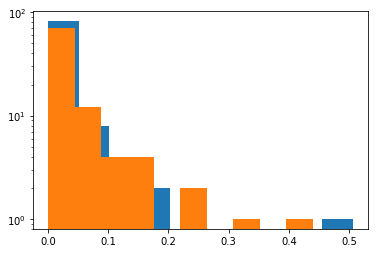

In [99]:
plt.hist(gaia['e_RPmag'], log=True)
plt.hist(gaia['e_BPmag'], log=True)

print(np.nanmedian(list(gaia['e_RPmag'])))